In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import cProfile
import time
import copy

import matplotlib.pyplot as plt

import ase.io

import sklearn.model_selection

from utils.dataset import AtomisticDataset, create_dataloader
from utils.soap import PowerSpectrum
from utils.combine import CombineSpecies, CombineRadial, CombineRadialSpecies
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient

torch.set_default_dtype(torch.float64)

In [3]:
n_test = 100
n_train = 100

frames = ase.io.read("data/xyz/data_shuffle.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor(
    [frame.info["energy"] for frame in train_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

test_energies = torch.tensor(
    [frame.info["energy"] for frame in test_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

train_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
    for frame in train_frames
]

test_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype()) 
    for frame in test_frames
]

print(f"using {n_train} training frames")

using 100 training frames


In [4]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 4.0,
    "max_angular": 4,
    "max_radial": 8,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    # TODO: implement this in rascaline itself
    "radial_per_angular": {
        # l: n
        0: 8,
        1: 6,
        2: 4,
        3: 3,
        4: 2,
    }
}

# Optimization loop, energies only

In [5]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

In [6]:
train_dataset = AtomisticDataset(train_frames, all_species, HYPERS_SMALL, train_energies)
test_dataset = AtomisticDataset(test_frames, all_species, HYPERS_SMALL, test_energies)

HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
HYPERS_GRAD["gradients"] = True
train_dataset_grad = AtomisticDataset(train_frames, all_species, HYPERS_GRAD, train_energies, train_forces)
test_dataset_grad = AtomisticDataset(test_frames, all_species, HYPERS_GRAD, test_energies, test_forces)

In [7]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_dataloader_grad = create_dataloader(
    train_dataset_grad,
    batch_size=512,
    shuffle=True,
    device=device,
)

train_dataloader_grad_no_batch = create_dataloader(
    train_dataset_grad,
    batch_size=len(train_dataset_grad),
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    device=device,
)

test_dataloader_grad = create_dataloader(
    test_dataset_grad,
    batch_size=100,
    shuffle=False,
    device=device,
)

In [8]:
def loss_optimizer(predicted, actual, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_optimizer_forces(predicted, actual, predicted_f, actual_f, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    loss += torch.linalg.norm(predicted_f.flatten() - actual_f.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_mae(predicted, actual):
    return torch.mean(torch.abs(predicted.flatten() - actual.flatten()))

def loss_rmse(predicted, actual):
    return torch.sqrt(torch.mean((predicted.flatten() - actual.flatten())**2))

In [9]:
class CombinedLinearModel(torch.nn.Module):
    def __init__(self, 
        combiner,
        regularizer,
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()
        self.combiner = combiner
        self.power_spectrum = PowerSpectrum()
        self.model = LinearModel(
            regularizer=regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )

        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, spherical_expansion, forward_forces=False):
        if not forward_forces:
            # remove gradients from the spherical expansion if we don't need it
            spherical_expansion = remove_gradient(spherical_expansion)

        combined = self.combiner(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)        
        power_spectrum_per_structure = self.sum_structure(power_spectrum)
        energies, forces = self.model(power_spectrum_per_structure, with_forces=forward_forces)
        return energies, forces

    def initialize_model_weights(self, spherical_expansion, energies, forces=None):
        if forces is None:
            # remove gradients from the spherical expansion if we don't need it
            spherical_expansion = remove_gradient(spherical_expansion)

        combined = self.combiner(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        
        power_spectrum_per_structure = self.sum_structure(power_spectrum)
        self.model.initialize_model_weights(power_spectrum_per_structure, energies, forces)
        

In [10]:
N_PSEUDO_SPECIES = 4
TORCH_REGULARIZER = 1e-2
LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

N_COMBINED_RADIAL = 4

# species combination only
combiner = CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES)

# # species combination and then radial basis combination
# combiner = torch.nn.Sequential(
#     CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES),
#     CombineRadial(max_radial=HYPERS_SMALL["max_radial"], n_combined_radial=N_COMBINED_RADIAL),
# )

# # combine both radial and species information at the same time
# combiner = CombineRadialSpecies(
#     n_species=len(all_species), 
#     max_radial=HYPERS_SMALL["max_radial"], 
#     n_combined_basis=N_COMBINED_RADIAL*N_PSEUDO_SPECIES,
# )

model = CombinedLinearModel(
    combiner=combiner, 
    regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True,
    random_initial_weights=True,
)

In [11]:
model.to(device=device, dtype=torch.get_default_dtype())

# initialize the model
with torch.no_grad():
    for spherical_expansions, energies, _ in train_dataloader_no_batch:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        model.initialize_model_weights(spherical_expansions, energies)

if model.optimizable_weights:
    torch_loss_regularizer = TORCH_REGULARIZER
else:
    torch_loss_regularizer = 0
    # we can not use batches if we are training with linear algebra, we need to
    # have all training frames available
    assert train_dataloader.batch_size >= len(train_frames)

In [12]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)

all_losses = []

filename = f"{model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if model.optimizable_weights:
    filename += "-opt-weights"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [13]:
for epoch in range(10):
    epoch_start = time.time()

    for spherical_expansions, energies, _ in train_dataloader:
        def single_step():
            optimizer.zero_grad()
        
            assert model.optimizable_weights
                
            predicted, _ = model(spherical_expansions, forward_forces=False)

            loss = loss_optimizer(
                predicted, 
                energies, 
                torch_loss_regularizer, 
                model.model.weights
            )
            loss.backward(retain_graph=False)

            return loss
            
        loss = optimizer.step(single_step)
        all_losses.append(loss.item())

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            reference = []
            for spherical_expansions, energies, _ in test_dataloader:
                reference.append(energies)
                predicted_e, _ = model(spherical_expansions, forward_forces=False)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted, reference)

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss.item():.4}, test mae={mae:.4}")
        
    n_epochs_total += 1

epoch 0 took 4.32s, optimizer loss=1.029e+07, test mae=175.4
epoch 1 took 4.433s, optimizer loss=5.003e+06, test mae=65.1
epoch 2 took 4.287s, optimizer loss=3.053e+05, test mae=26.42
epoch 3 took 4.22s, optimizer loss=2.155e+04, test mae=21.78
epoch 4 took 4.23s, optimizer loss=7.716e+03, test mae=19.46
epoch 5 took 4.237s, optimizer loss=4.423e+03, test mae=18.92
epoch 6 took 4.221s, optimizer loss=3.153e+03, test mae=18.64
epoch 7 took 4.305s, optimizer loss=2.043e+03, test mae=18.69
epoch 8 took 4.277s, optimizer loss=1.506e+03, test mae=19.27
epoch 9 took 4.337s, optimizer loss=1.213e+03, test mae=19.37


# Predicting forces with forward propagation

In [14]:
def evaluate_model_with_forces(model, dataloader):
    predicted_e = []
    reference_e = []
    predicted_f = []
    reference_f = []
    for spherical_expansions, energies, forces in dataloader:
        reference_e.append(energies)
        reference_f.append(forces)
        e, f = model(spherical_expansions, forward_forces=True)
        predicted_e.append(e)
        predicted_f.append(f)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)

    reference_f = torch.vstack(reference_f)
    predicted_f = torch.vstack(predicted_f)

    return reference_e, predicted_e, reference_f, predicted_f

In [15]:
def parity_plots(reference_e, predicted_e, reference_f, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = loss_rmse(predicted_e, reference_e)
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, reference_f)
    rmse = loss_rmse(predicted_f, reference_f)
    ax_f.scatter(reference_f.cpu(), predicted_f.cpu())
    x = (torch.min(reference_f.flatten()).item(), torch.max(reference_f.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

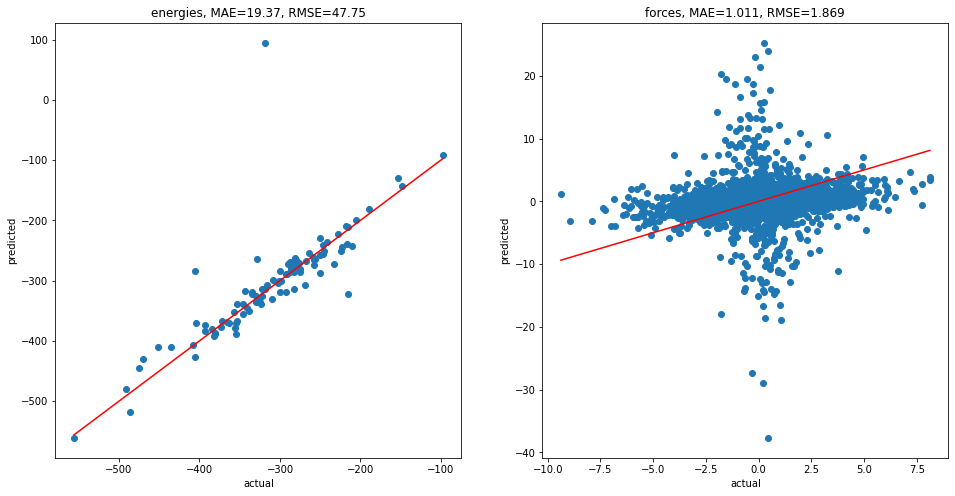

In [16]:
reference_e, predicted_e, reference_f, predicted_f = evaluate_model_with_forces(model, test_dataloader_grad)
fig = parity_plots(reference_e, predicted_e, reference_f, predicted_f)

In [17]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset([frame, delta_frame], all_species, HYPERS_GRAD, torch.zeros(2, 1))
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for spherical_expansion, _, _ in dataloader:
        predicted_e, predicted_f = model(spherical_expansion, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [18]:
if torch.get_default_dtype() == torch.float64:
    delta = 1e-6
else:
    delta = 1e-3

check_finite_differences(model, train_frames[22], delta)

finite difference = -0.2896298951782228
computed gradient = -0.2896292067160195


## Training with forces, linear algebra

In [19]:
linear_algebra_model = CombinedLinearModel(
    combiner=model.combiner,
    regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=False,
    random_initial_weights=False, # <<<<==== VERY IMPORTANT
)

In [20]:
with torch.no_grad():
    for spherical_expansions, energies, forces in train_dataloader_grad_no_batch:
        linear_algebra_model.initialize_model_weights(spherical_expansions, energies, forces)

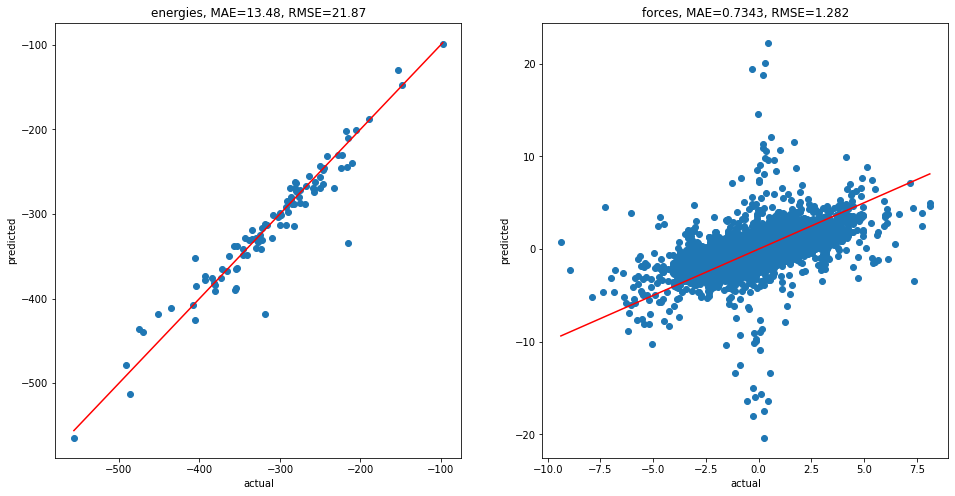

In [21]:
reference_e, predicted_e, reference_f, predicted_f = evaluate_model_with_forces(
    linear_algebra_model, test_dataloader_grad
)

fig = parity_plots(reference_e, predicted_e, reference_f, predicted_f)

# Optimization loop, energies and forces

In [23]:
for epoch in range(1):
    epoch_start = time.time()

    for spherical_expansions, energies, forces in train_dataloader_grad:
        def single_step():
            optimizer.zero_grad()
           
            assert model.optimizable_weights
            predicted_e, predicted_f = model(spherical_expansions, forward_forces=True)

            loss = loss_optimizer_forces(
                predicted_e,
                energies,
                predicted_f,
                forces,
                torch_loss_regularizer,
                model.model.weights
            )
            loss.backward(retain_graph=False)

            return loss
            
        loss = optimizer.step(single_step)
        all_losses.append(loss.item())

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        # with torch.no_grad():
        #     for spherical_expansions, energies, forces in test_dataloader_grad_no_batch:
        #         predicted_e, predicted_f = model(spherical_expansions, forward_forces=False)

        #     energy_mae = loss_mae(predicted_e, energies)
        #     forces_mae = 0.0  # loss_mae(predicted_f, forces)

        #     output.write(f"{n_epochs_total} {loss} {energy_mae}\n")
        #     output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss.item():.4}")
        
    n_epochs_total += 1

epoch 5 took 331.3s, optimizer loss=1.47e+04


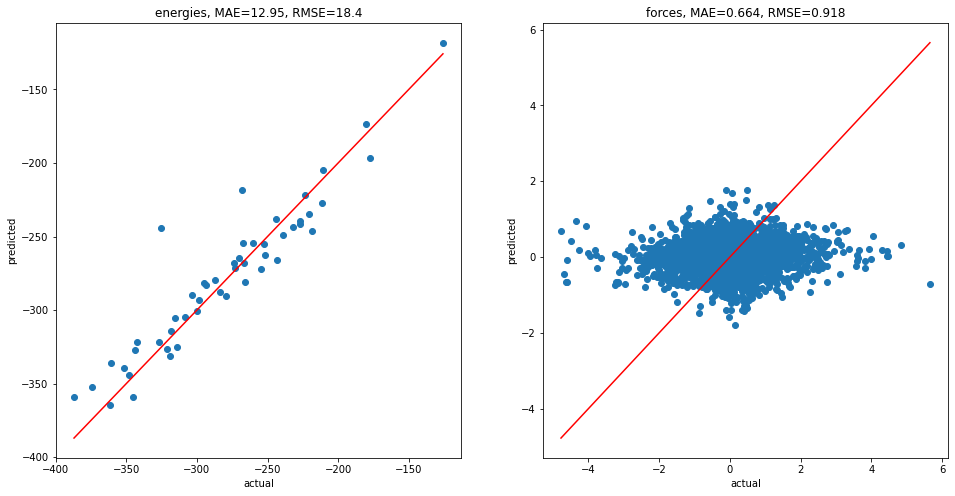

In [24]:
reference_e, predicted_e, reference_f, predicted_f = evaluate_model_with_forces(model, test_dataloader_grad)

fig = parity_plots(reference_e, predicted_e, reference_f, predicted_f)

# TODO: predicting forces with backward propagation